# DS4A Team 27: Multivariate Exploratory Data Analysis - Mortality Rates and Air Pollution Indicators (as well as pollutant single variable eda) 

CONCLUSIONS:

Pollution EDA Conclusions:
- Pollutants levels in inner radius CCGs are comparable or LOWER (PM2.5 and ozone) than outer radius CCGs. 
- Using the middle of a CCG as "distance from heathrow," it appears that pollutant levels in CCGs further from the airport are higher. 
- **Both of these metrics contradict our hypothesis that pollution is worse closer to the airport.**
- These findings suggest that we need better methods to measure inner/outer CCGs and distance from airport, OR that pollution levels are truly lower closer to the airport. 

Pollution and Mortality EDA Takeaways that Support our Hypothesis: 
- Death by coronary heart disease (for people under 75 years) is positively correlated with higher levels of sulphur dioxide (0.55), PM10 (0.43), Nitrogen dioxide (0.33) and PM2.5 (0.13) - supports our hypothesis 
- Death by respiratory disease (for people under 75) is positively correlated with higher levels of nitrogen dioxide (0.45), sulphur dioxide (0.30), and PM10 (0.22) - this supports our hypoethesis  

Pollution and Mortality EDA Takeaways that Contradict our Hypothesis: 
- Death by asthma is (barely) positively correlated with higher levels of PM10 (0.02) 
- Death with COPD as a contributory cause is positively correlated with nitrogen dioxide (0.35) but negatively correlated with PM10, PM2.5, and sulphur dioxide - shocking 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 1. Load in mortality data

In [2]:
df = pd.read_csv('./cleaned_data_output/mortality_data_select/cleaned_mortality_data_select.csv')
df.head(3)

,Unnamed: 0,Unnamed: 0.1,Indicator ID,Indicator Name,Area Code,Area Name,Area Type,Sex,Age,Time period,...,Lower CI 99.8 limit,Upper CI 99.8 limit,Count,Denominator,Value note,Compared to England value or percentiles,Time period Sortable,Radius,Indicator,Year
0,197,197,40701,Under 75 mortality rate from respiratory disease,E38000048,NHS Ealing CCG,CCGs (since 4/20),Persons,<75 yrs,2006 - 08,...,30.558250,47.490967,209.134,910471.0,NaN,Similar,2006,Inner,Under 75 Resp Disease,2006
1,198,198,40701,Under 75 mortality rate from respiratory disease,E38000082,NHS Hillingdon CCG,CCGs (since 4/20),Persons,<75 yrs,2006 - 08,...,28.352473,45.379217,180.242,723423.0,NaN,Similar,2006,Inner,Under 75 Resp Disease,2006
2,199,199,40701,Under 75 mortality rate from respiratory disease,E38000084,NHS Hounslow CCG,CCGs (since 4/20),Persons,<75 yrs,2006 - 08,...,29.929550,49.787453,159.040,665684.0,NaN,Similar,2006,Inner,Under 75 Resp Disease,2006


### 2. Filter to relevant data and rename 

In [3]:
# select relevant columns
df = df[["Indicator Name", "Indicator", "Area Name", "Radius", "Year", "Time period", "Value"]]
# rename columsn 
df_H = df.rename(columns={"Indicator Name": "Indicator Full Name", 
    "Value":"Mortality Rate"})
df_H.head()

,Indicator Full Name,Indicator,Area Name,Radius,Year,Time period,Mortality Rate
0,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Ealing CCG,Inner,2006,2006 - 08,38.388443
1,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Hillingdon CCG,Inner,2006,2006 - 08,36.176786
2,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Hounslow CCG,Inner,2006,2006 - 08,39.003001
3,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Buckinghamshire CCG,Inner,2006,2006 - 08,25.653613
4,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS East Berkshire CCG,Inner,2006,2006 - 08,31.198377


In [4]:
# remove the erroneous indicator 
df_H = df_H[df_H['Area Name'] != 'NHS Basildon And Brentwood CCG']

# remove locations not supported by pollution data
not_supported_poll = [
    'NHS Brent CCG',
    'NHS Croydon CCG',
    'NHS Guildford and Waverley CCG',
    'NHS Harrow CCG',
]

df_H = df_H[~df_H['Area Name'].isin(not_supported_poll)]

In [5]:
df_H["Area Name"].unique()

array(['NHS Ealing CCG', 'NHS Hillingdon CCG', 'NHS Hounslow CCG',
       'NHS Buckinghamshire CCG', 'NHS East Berkshire CCG',
       'NHS North West Surrey CCG', 'NHS Hammersmith And Fulham CCG',
       'NHS Herts Valleys CCG', 'NHS Oxfordshire CCG',
       'NHS Surrey Heath CCG', 'NHS Berkshire West CCG',
       'NHS Kingston CCG', 'NHS Merton CCG', 'NHS Richmond CCG',
       'NHS Sutton CCG', 'NHS Wandsworth CCG'], dtype=object)

### 3. Get NHS CCG distances and add to mortality data 

In [6]:
inner_ccgs = ['NHS Buckinghamshire CCG', 'NHS Ealing CCG', 'NHS East Berkshire CCG', 'NHS Hillingdon CCG',
 'NHS Hounslow CCG', 'NHS North West Surrey CCG']

outer_ccgs =  ['NHS Berkshire West CCG', 'NHS Hammersmith And Fulham CCG', 
               'NHS Herts Valleys CCG', 'NHS Kingston CCG', 'NHS Merton CCG', 'NHS Oxfordshire CCG', 
               'NHS Richmond CCG', 'NHS Surrey Heath CCG', 'NHS Sutton CCG', 'NHS Wandsworth CCG']

# HJammersmith & Fulham and Basingham(?) renamed to match the lists above. alternatively, make lowercase prior to join
geog = pd.read_csv('./geo_data/nhs_ccg_geometry.csv', encoding='utf-8')
geog_ccg = geog[geog['Area Name'].isin(inner_ccgs + outer_ccgs)]
geog_ccg.head()

,Unnamed: 0,OBJECTID,CCG19CD,Area Name,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,heathrow_distance
38,38,39,E38000048,NHS Ealing CCG,517058,181961,-0.31405,51.5244,5.552570e+07,47268.99455,11465.530930
55,55,56,E38000070,NHS Hammersmith And Fulham CCG,523867,177994,-0.21735,51.4873,1.640417e+07,23889.00847,16573.145490
63,63,64,E38000079,NHS Herts Valleys CCG,506779,204790,-0.45521,51.7317,5.850515e+08,173333.71070,29114.522130
66,66,67,E38000082,NHS Hillingdon CCG,508167,183120,-0.44180,51.5366,1.156987e+08,63839.53152,7458.185529
68,68,69,E38000084,NHS Hounslow CCG,512742,174962,-0.37847,51.4624,5.598698e+07,61276.53622,5336.984712


In [7]:
df_H_dist = pd.merge(df_H, geog_ccg[['Area Name', 'heathrow_distance']], how='left', on='Area Name')
df_H_dist.head(3)

,Indicator Full Name,Indicator,Area Name,Radius,Year,Time period,Mortality Rate,heathrow_distance
0,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Ealing CCG,Inner,2006,2006 - 08,38.388443,11465.530930
1,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Hillingdon CCG,Inner,2006,2006 - 08,36.176786,7458.185529
2,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Hounslow CCG,Inner,2006,2006 - 08,39.003001,5336.984712


In [8]:
# we need to create a pollution CCG mapping (as some of the CCG locations have shared pollution indicators)
pollution_map = {
    'NHS Buckinghamshire CCG': 'Watford',
    'NHS Ealing CCG': 'Ealing', 
    'NHS East Berkshire CCG': 'East Berkshire', 
    'NHS Hillingdon CCG': 'Hillingdon',
    'NHS Hounslow CCG': 'Hounslow', 
    'NHS North West Surrey CCG': 'Surrey Heartlands',
    'NHS Berkshire West CCG': 'Reading', 
    'NHS Hammersmith And Fulham CCG': 'Hammersmith and Fulham', 
    'NHS Herts Valleys CCG': 'Watford', 
    'NHS Kingston CCG': 'South West London', 
    'NHS Merton CCG': 'South West London', 
    'NHS Oxfordshire CCG': 'Oxford', 
    'NHS Richmond CCG': 'South West London', 
    'NHS Surrey Heath CCG': 'Reading', # closest data point. review.
    'NHS Sutton CCG': 'South West London', 
    'NHS Wandsworth CCG': 'South West London'
}


df_H_dist['CCG_Poll_Map'] = df_H_dist['Area Name'].map(pollution_map)
df_H_dist.head(3)

,Indicator Full Name,Indicator,Area Name,Radius,Year,Time period,Mortality Rate,heathrow_distance,CCG_Poll_Map
0,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Ealing CCG,Inner,2006,2006 - 08,38.388443,11465.530930,Ealing
1,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Hillingdon CCG,Inner,2006,2006 - 08,36.176786,7458.185529,Hillingdon
2,Under 75 mortality rate from respiratory disease,Under 75 Resp Disease,NHS Hounslow CCG,Inner,2006,2006 - 08,39.003001,5336.984712,Hounslow


In [9]:
df_H_pivot = df_H_dist.pivot_table(
    values='Mortality Rate',
    index= ['Year', 'Area Name', 'heathrow_distance', 'Radius', 'CCG_Poll_Map'],
    columns='Indicator'
).reset_index()

In [10]:
df_H_pivot

Indicator,Year,Area Name,heathrow_distance,Radius,CCG_Poll_Map,<75 Coronary Heart Disease,Asthma,COPD (contributory cause),Pneumonia (all mentions),Under 75 Resp Disease
0,2003,NHS Berkshire West CCG,49791.74229,Outer,Reading,57.82,NaN,NaN,NaN,NaN
1,2003,NHS Buckinghamshire CCG,38818.06153,Inner,Watford,51.21,NaN,NaN,NaN,NaN
2,2003,NHS Ealing CCG,11465.53093,Inner,Ealing,82.91,NaN,NaN,NaN,NaN
3,2003,NHS East Berkshire CCG,15803.71343,Inner,East Berkshire,67.88,NaN,NaN,NaN,NaN
4,2003,NHS Hammersmith And Fulham CCG,16573.14549,Outer,Hammersmith and Fulham,75.75,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
235,2017,NHS Oxfordshire CCG,66982.40789,Outer,Oxford,25.18,2.936432,37.179050,157.569246,24.624437
236,2017,NHS Richmond CCG,11948.41495,Outer,South West London,26.73,NaN,NaN,NaN,NaN
237,2017,NHS Surrey Heath CCG,23497.23959,Outer,Reading,16.08,NaN,35.046488,149.146323,17.639181
238,2017,NHS Sutton CCG,23268.28951,Outer,South West London,22.89,NaN,NaN,NaN,NaN


### 4. Load in pollutant data, clean pollutant data, concatenate 

In [11]:
# load in 
inner_poll = pd.read_csv('./poll_data/inner_poll.csv', encoding='utf-8')
# clean up 
inner_poll.rename(columns={'CCG':'CCG_Poll_Map', 'Date':'Year'}, inplace=1)
inner_poll["Year"] = inner_poll["Year"].apply(lambda x: x[:4])
inner_poll.drop(columns = ['Unnamed: 0'], inplace=True)
# pivot
inner_poll = inner_poll.pivot_table(
    values='Indicator Value (R µg/m3)',
    index= ['Year', 'CCG_Poll_Map'],
    columns='Pollutant'
).reset_index()
inner_poll = inner_poll.rename(columns={'PM10 particulate matter (Hourly measured)':'PM10', 'PM2.5 particulate matter (Hourly measured)':'PM2.5'})
# only keep pollutants also measured in outer CCGS
inner_poll = inner_poll[["Year", "CCG_Poll_Map", "Nitrogen dioxide", "Ozone", "PM10", "PM2.5", "Sulphur dioxide"]]
inner_poll

Pollutant,Year,CCG_Poll_Map,Nitrogen dioxide,Ozone,PM10,PM2.5,Sulphur dioxide
0,2004,Ealing,57.882938,33.992080,23.333576,15.391342,10.043232
1,2004,East Berkshire,32.568066,NaN,23.849996,NaN,NaN
2,2004,Hillingdon,44.523785,NaN,26.432311,12.248356,NaN
3,2004,Hounslow,57.171402,31.628426,NaN,NaN,4.155740
4,2004,South West London,32.177120,44.607494,22.974463,NaN,3.676630
...,...,...,...,...,...,...,...
97,2020,East Berkshire,21.927106,NaN,18.347784,7.578337,NaN
98,2020,Hillingdon,24.166254,NaN,16.255368,6.760637,NaN
99,2020,Hounslow,26.898693,36.224711,NaN,NaN,2.069656
100,2020,South West London,18.563667,49.654238,16.859590,NaN,NaN


In [12]:
# load in 
outer_poll = pd.read_csv('./poll_data/outer_poll.csv', encoding='utf-8')
# clean up 
outer_poll.rename(columns={'CCG':'CCG_Poll_Map', 'Date':'Year', 'PM10 particulate matter (Hourly measured)':'PM10', 'PM2.5 particulate matter (Hourly measured)':'PM2.5'}, inplace=1)
outer_poll["Year"] = outer_poll["Year"].apply(lambda x: x[:4])
# show
outer_poll

,Year,CCG_Poll_Map,Nitrogen dioxide,Ozone,PM10,PM2.5,Sulphur dioxide
0,2004,Hammersmith and Fulham,58.655707,NaN,26.158435,NaN,9.171105
1,2004,Oxford,63.545897,40.376279,27.789444,NaN,NaN
2,2004,Watford,38.836547,37.226716,24.200917,NaN,NaN
3,2005,Hammersmith and Fulham,52.325337,NaN,30.948655,NaN,8.271812
4,2005,Oxford,49.362863,39.652825,25.594434,NaN,NaN
...,...,...,...,...,...,...,...
60,2019,Watford,30.165464,NaN,15.055914,9.476284,NaN
61,2020,Hammersmith and Fulham,38.665017,38.114023,22.318335,13.631648,NaN
62,2020,Oxford,28.006868,46.380779,15.914070,NaN,NaN
63,2020,Reading,22.337960,NaN,19.421970,NaN,NaN


In [13]:
df_P = inner_poll.append(outer_poll)
df_P

Pollutant,Year,CCG_Poll_Map,Nitrogen dioxide,Ozone,PM10,PM2.5,Sulphur dioxide
0,2004,Ealing,57.882938,33.992080,23.333576,15.391342,10.043232
1,2004,East Berkshire,32.568066,NaN,23.849996,NaN,NaN
2,2004,Hillingdon,44.523785,NaN,26.432311,12.248356,NaN
3,2004,Hounslow,57.171402,31.628426,NaN,NaN,4.155740
4,2004,South West London,32.177120,44.607494,22.974463,NaN,3.676630
...,...,...,...,...,...,...,...
60,2019,Watford,30.165464,NaN,15.055914,9.476284,NaN
61,2020,Hammersmith and Fulham,38.665017,38.114023,22.318335,13.631648,NaN
62,2020,Oxford,28.006868,46.380779,15.914070,NaN,NaN
63,2020,Reading,22.337960,NaN,19.421970,NaN,NaN


### 5. Join mortality and pollutant data on "CCG_Poll_Map" and "Year" columns 

In [14]:
# fix year column for merging 
df_P["Year"] =df_P["Year"].apply(lambda x: int(x))
# merge 
merged_df = df_H_pivot.merge(df_P, how='inner', left_on=["CCG_Poll_Map", "Year"], right_on=["CCG_Poll_Map", "Year"])
# show 
merged_df.head(3)

,Year,Area Name,heathrow_distance,Radius,CCG_Poll_Map,<75 Coronary Heart Disease,Asthma,COPD (contributory cause),Pneumonia (all mentions),Under 75 Resp Disease,Nitrogen dioxide,Ozone,PM10,PM2.5,Sulphur dioxide
0,2004,NHS Buckinghamshire CCG,38818.06153,Inner,Watford,46.66,NaN,NaN,NaN,NaN,38.836547,37.226716,24.200917,NaN,NaN
1,2004,NHS Herts Valleys CCG,29114.52213,Outer,Watford,48.24,NaN,NaN,NaN,NaN,38.836547,37.226716,24.200917,NaN,NaN
2,2004,NHS Ealing CCG,11465.53093,Inner,Ealing,70.77,NaN,NaN,NaN,NaN,57.882938,33.992080,23.333576,15.391342,10.043232


In [15]:
merged_df.shape

(219, 15)

### 6. Single variable analysis on pollutants

In [16]:
# First let's just see if pollutants go up further from the airport: 
pollutants = ['Nitrogen dioxide', 'Ozone', 'PM10', 'PM2.5', 'Sulphur dioxide']

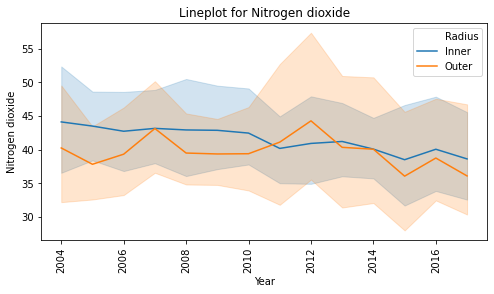

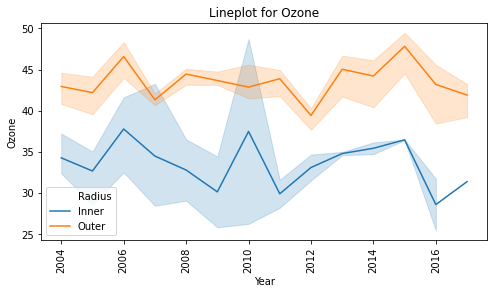

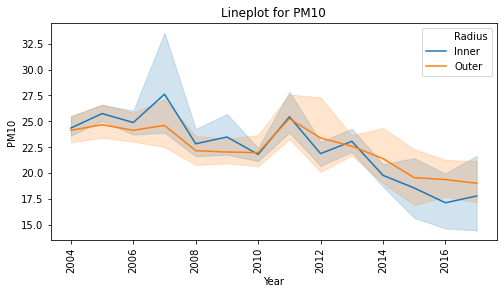

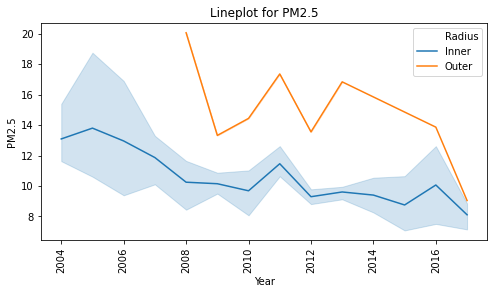

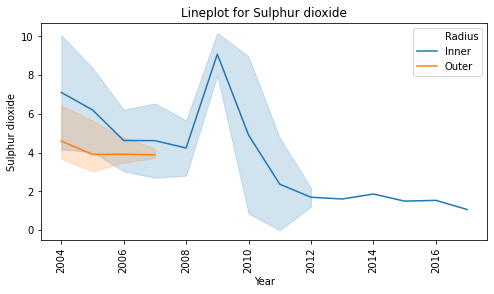

In [17]:
# create graphs using inner/outer designation
for i in pollutants: 
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.lineplot(x="Year", y=i, data=merged_df[[i, 'Radius', 'Year']], ax=ax, hue='Radius')
    plt.xticks(rotation=90)
    title = "Lineplot for " + str(i)
    plt.title(title)

Taking a step back and just plotting pollutant levels according to our Inner/Outer Radius category - it does NOT seem clear that pollutant levels are higher closer to the airport. In fact, for levels of PM2.5 and ozone are actually lower in the inner radius. This contradicts our initial hypothesis. Let's use the "distance from heathrow" column instead of our "Inner/Outer" category: 

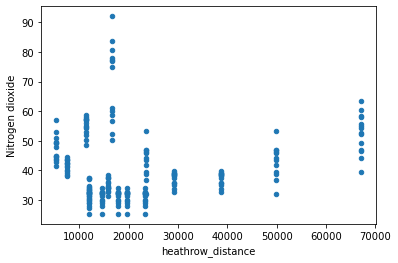

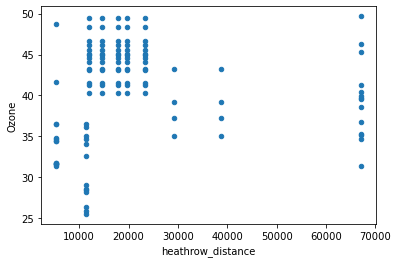

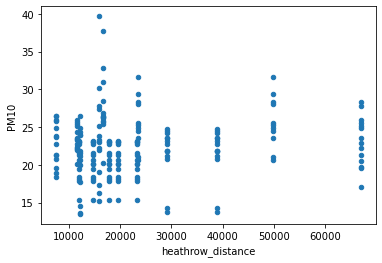

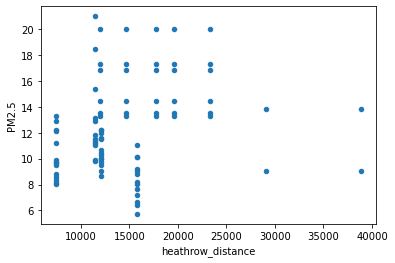

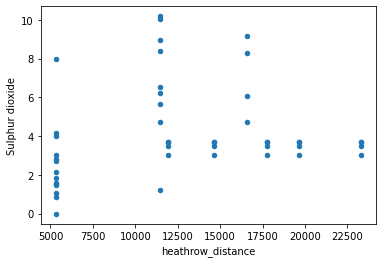

In [18]:
# create graphs using distance from airport
for poll in pollutants:
    merged_df.plot.scatter(x="heathrow_distance", y=poll)

For each of the five pollutants, I don't see a clear correlation between distance from the airport and levels of the pollutant. Let's look at some correlation coefficients. 

In [19]:
# Calculate correlation coefficients 
for p in pollutants: 
    print("Correlation coefficient between distance from healthrow and pollutant levels for: ", p)
    print(merged_df.corr()['heathrow_distance'][p])

Correlation coefficient between distance from healthrow and pollutant levels for:  Nitrogen dioxide
0.14933354180510186
Correlation coefficient between distance from healthrow and pollutant levels for:  Ozone
0.03964613369988308
Correlation coefficient between distance from healthrow and pollutant levels for:  PM10
0.11570645579376944
Correlation coefficient between distance from healthrow and pollutant levels for:  PM2.5
0.22108600724033764
Correlation coefficient between distance from healthrow and pollutant levels for:  Sulphur dioxide
0.17880890802428542


Conclusions:
- Pollutants levels in inner radius CCGs are comparable or LOWER (PM2.5 and ozone) than outer radius CCGs. 
- Using the middle of a CCG as "distance from heathrow," it appears that pollutant levels in CCGs further from the airport are higher. 
- Both of these metrics contradict our hypothesis that pollution is worse closer to the airport. 
- These findings suggest that we need better methods to measure inner/outer CCGs and distance from airport, OR that pollution levels are truly lower closer to the airport. 

### 7. Multi-variable analysis on mortality data and pollutants 

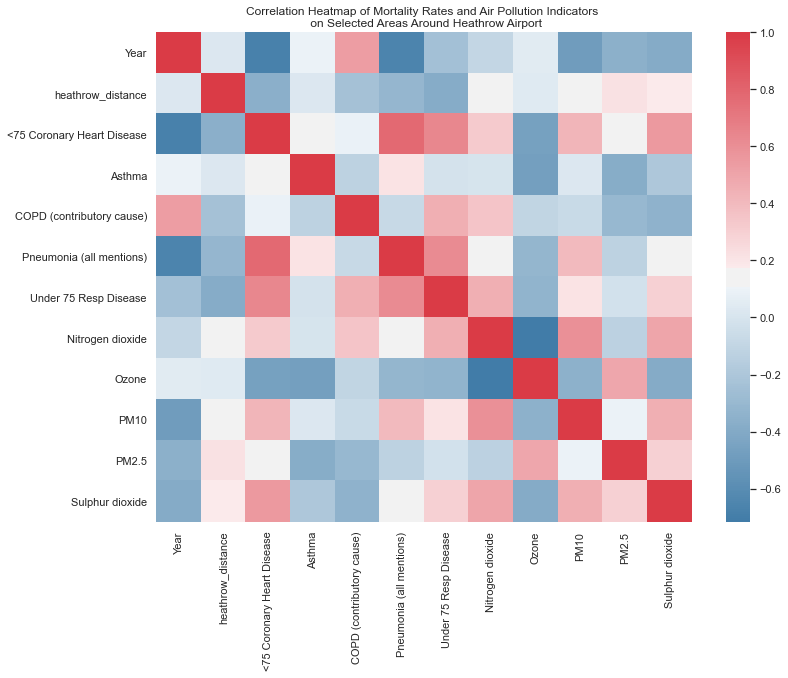

In [20]:
# correlation heatmap matrix
sns.set(rc={'figure.figsize':(12,9)})

# https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
cmap= sns.diverging_palette(240, 10, as_cmap=True)

corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, cmap=cmap)

plt.title('Correlation Heatmap of Mortality Rates and Air Pollution Indicators \n on Selected Areas Around Heathrow Airport')
plt.show()

In [21]:
# Let's get that in numbers: 
corr_matrix

,Year,heathrow_distance,<75 Coronary Heart Disease,Asthma,COPD (contributory cause),Pneumonia (all mentions),Under 75 Resp Disease,Nitrogen dioxide,Ozone,PM10,PM2.5,Sulphur dioxide
Year,1.000000,0.024121,-0.679004,0.095897,0.533097,-0.661264,-0.240457,-0.095222,0.044193,-0.488738,-0.354934,-0.391783
heathrow_distance,0.024121,1.000000,-0.364307,0.024596,-0.235642,-0.308319,-0.386810,0.149334,0.039646,0.115706,0.221086,0.178809
<75 Coronary Heart Disease,-0.679004,-0.364307,1.000000,0.168475,0.090599,0.779434,0.643218,0.325641,-0.460823,0.429256,0.125880,0.552009
Asthma,0.095897,0.024596,0.168475,1.000000,-0.122511,0.215879,-0.014749,-0.001126,-0.470782,0.022315,-0.380117,-0.195680
COPD (contributory cause),0.533097,-0.235642,0.090599,-0.122511,1.000000,-0.077789,0.454775,0.350155,-0.103069,-0.067301,-0.304012,-0.341097
Pneumonia (all mentions),-0.661264,-0.308319,0.779434,0.215879,-0.077789,1.000000,0.624213,0.162118,-0.317178,0.402787,-0.121411,0.169048
Under 75 Resp Disease,-0.240457,-0.386810,0.643218,-0.014749,0.454775,0.624213,1.000000,0.451985,-0.328778,0.215142,-0.020277,0.296467
Nitrogen dioxide,-0.095222,0.149334,0.325641,-0.001126,0.350155,0.162118,0.451985,1.000000,-0.715623,0.595857,-0.128065,0.502217
Ozone,0.044193,0.039646,-0.460823,-0.470782,-0.103069,-0.317178,-0.328778,-0.715623,1.000000,-0.352486,0.490900,-0.388233
PM10,-0.488738,0.115706,0.429256,0.022315,-0.067301,0.402787,0.215142,0.595857,-0.352486,1.000000,0.096535,0.450881


Takeaways that support our hypothesis: 
- Death by coronary heart disease (for people under 75 years) is positively correlated with higher levels of sulphur dioxide (0.55), PM10 (0.43), Nitrogen dioxide (0.33) and PM2.5 (0.13) - supports our hypothesis 
- Death by respiratory disease (for people under 75) is positively correlated with higher levels of nitrogen dioxide (0.45), sulphur dioxide (0.30), and PM10 (0.22) - this supports our hypoethesis  

Takeaways that contradict our hypothesis: 
- Death by asthma is (barely) positively correlated with higher levels of PM10 (0.02) 
- Death with COPD as a contributory cause is positively correlated with nitrogen dioxide (0.35) but negatively correlated with PM10, PM2.5, and sulphur dioxide - shocking 